<a href="https://colab.research.google.com/github/gomezphd/CAI2300C_NLP/blob/main/NLP_Gomez_Psy_CC_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MDC 2300C: Introduction to Natural Language Processing**

## **Assignment 2**: Building a Semantic Search Engine with OpenAI (Psychology Clinic Application)

**Student**: Carlos C. Gomez
**Date**: March 2025  
**Professor**: Dr. Ernesto Lee  

---



## **Introduction and Project Overview**

This notebook implements a **semantic search engine** for psychology clinic patient presentations using OpenAI's embedding models. The system is designed to help clinical psychology students and educators find semantically similar patient cases based on natural language descriptions of symptoms.

### **Key Features**
- **Domain-Specific Dataset**: 30 realistic clinical presentations covering various psychological disorders
- **Clinical Classification**: Automatic categorization of presentations by diagnostic category
- **Severity Assessment**: Clinical severity evaluation based on symptom descriptions
- **Symptom Duration**: Classification of chronicity patterns
- **Treatment Consideration**: Optional integration of evidence-based treatment approaches
- **Interactive Interface**: User-friendly Gradio interface for querying the system

### **Educational Purpose**
**This tool is designed for **educational purposes only** and not for actual clinical decision-making. It demonstrates how natural language processing can help psychology students and educators explore relationships between clinical presentations and diagnostic categories.**

---

### **Methodology**

This project follows a structured approach to implementing semantic search for clinical psychology:

1. **Data Preparation**
   - Creation of a diverse dataset of clinical presentations
   - Development of classification functions for diagnostic categories
   - Implementation of severity and duration assessment logic

2. **Semantic Embedding**
   - Conversion of clinical text to vector representations using OpenAI's text-embedding-3-small model
   - Preservation of semantic meaning in a high-dimensional vector space
   - Analysis of embedding patterns within diagnostic categories

3. **Search Implementation**
   - Cosine similarity calculation between query and clinical presentations
   - Ranking of results by semantic relevance
   - Integration of clinical metadata in search results

4. **Visualization and Analysis**
   - Distribution analysis of diagnostic categories
   - Severity and duration pattern visualization
   - Co-occurrence analysis of clinical symptoms
   - Performance evaluation of search functionality

5. **User Interface Development**
   - Creation of an intuitive Gradio interface
   - Integration of example queries for demonstration
   - Implementation of treatment consideration options

---
## **1. Environment Setup**

This section configures the Python environment with all necessary libraries and tools for building the semantic search engine:

- **OpenAI API**: For accessing embedding models
- **Gradio**: For creating the interactive interface
- **NumPy & SciPy**: For numerical operations and distance calculations
- **Pandas & Matplotlib**: For data analysis and visualization

Helper functions are also defined for consistent formatting and OpenAI API interaction, including an embedding generation function that handles batch processing for efficiency.

In [1]:
print("Environment Setup")
print("#--------------------------------")

!pip install openai gradio -q

# Important clinical disclaimer
print("\n" + "!" * 80)
print("IMPORTANT: This analysis is provided for educational purposes only.")
print("Clinical decision-making should rely on comprehensive assessment by qualified")
print("healthcare professionals following evidence-based practice guidelines.")
print("!" * 80)


1. Initial Setup and Imports
#--------------------------------
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine

In [2]:
# Import necessary libraries
import numpy as np
from scipy.spatial import distance
from openai import OpenAI
import gradio as gr
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import string
import time
from google.colab import userdata  # For secure API key access

print("Setting up environment...")

# Initialize OpenAI client with your API key (stored securely)
api_key = userdata.get('OpenAI')  # Get API key from Colab secrets
client = OpenAI(api_key=api_key)

# Formatting helper functions
def print_header(title, char="="):
    """
    Print a major section header with centered title and borders.

    Args:
        title (str): The title to display
        char (str): Character to use for the border (default: '=')
    """
    border = char * 60
    print(f"\n{border}\n{title.center(60)}\n{border}\n")

def print_section(title, char="-"):
    """
    Print a subsection header with title and borders.

    Args:
        title (str): The title to display
        char (str): Character to use for the border (default: '-')
    """
    print(f"\n{char * 40}\n{title}\n{char * 40}")

# Define the embedding function using the OpenAI client
def create_embeddings(texts, model="text-embedding-3-small"):
    """
    Create embeddings for a list of texts using OpenAI API.

    Args:
        texts (list): List of text strings to embed
        model (str): The OpenAI model to use for embeddings

    Returns:
        list: List of embedding vectors
    """
    embeddings = []
    # Process in batches to handle potential rate limits
    batch_size = 20  # Adjust based on API limits

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        try:
            response = client.embeddings.create(
                input=batch,
                model=model
            )
            batch_embeddings = [data.embedding for data in response.data]
            embeddings.extend(batch_embeddings)

            # Add a small delay to avoid rate limits if needed
            if i + batch_size < len(texts):
                time.sleep(0.5)

        except Exception as e:
            print(f"Error generating embeddings for batch {i}-{i+batch_size}: {e}")
            # Return empty list if there's an error
            return []

    return embeddings

print("Environment setup complete!")

Setting up environment...
Environment setup complete!


## **2. Data Preparation**

### **Synethic Clinical Dataset- AI Generated (Not actual cases)**

This section uses Generative AI to create a dataset of 30 mock clinical presentations representative of common psychological conditions encountered in clinical practice. The presentations span various types of psychological concerns including:

* Mood disorders (depression, bipolar disorder)
* Anxiety disorders (generalized anxiety, social anxiety, panic disorder)
* Trauma-related disorders (PTSD, acute stress disorder)
* Obsessive-compulsive and related disorders
* Eating and feeding disorders
* Psychotic disorders
* Personality disorders
* Neurodevelopmental disorders
* Sleep-wake disorders

Two classification functions are implemented to enrich the data:
1. **Diagnostic Category Classification**: Categorizes presentations based on their symptom patterns and clinical features
2. **Severity Assessment**: Assigns clinical severity levels (Severe/Moderate/Mild) based on functional impairment and symptom intensity
3. **Duration Estimation**: Determines chronicity pattern (Acute/Subacute/Chronic) based on temporal information

The dataset is then analyzed to understand its composition and distribution across diagnostic categories, severity levels, and duration patterns.

### **Classification Approach**
Each clinical presentation is automatically classified using an algorithm that identifies key symptom patterns in the text. The system:
- Recognizes diagnostic indicators such as "depressed mood," "intrusive thoughts," or "panic attacks"
- Evaluates severity based on functional impairment markers like "unable to work," "significant distress," or "daily occurrence"
- Estimates duration based on temporal references like "past month," "childhood," or "several years"

### **Educational Note**
This dataset is created for educational purposes and does not contain real patient information. The presentations are synthesized from clinical literature to represent typical symptom patterns seen in psychological practice.

In [3]:
print_header("2. Data Preparation")

# Psychology Clinic Dataset - Patient Presenting Problems
patient_presenting_problems = [
    "Patient reports persistent feelings of sadness, loss of interest in activities, sleep disturbances, and low energy levels for the past 4 months.",
    "Client exhibits intense fear and avoidance of social situations where they might be scrutinized, with physical symptoms including rapid heartbeat and sweating during social events.",
    "Individual describes recurrent, unexpected panic attacks with palpitations, shortness of breath, and fear of losing control occurring 2-3 times weekly.",
    "Patient presents with intrusive thoughts about contamination and repetitive handwashing (30+ times daily) that they recognize as excessive but cannot control.",
    "Client reports flashbacks, nightmares, and severe anxiety related to a car accident that occurred six months ago, avoiding driving since the incident.",
    "Individual demonstrates difficulty maintaining attention, excessive activity, and impulsive decision making that impairs academic performance and relationships.",
    "Patient expresses extreme concern with body weight despite being underweight (BMI 17.2), and engages in restrictive eating patterns, consuming less than 1000 calories daily.",
    "Client reports periods of elevated mood, decreased need for sleep (2-3 hours nightly), racing thoughts, and engaging in risky behaviors alternating with depressive episodes.",
    "Individual experiences auditory hallucinations telling them they are being watched and paranoid delusions that neighbors are plotting against them, causing significant social withdrawal.",
    "Patient describes persistent worry across multiple life domains that they find difficult to control, accompanied by muscle tension, fatigue, and difficulty concentrating.",
    "Client reports sudden mood swings, unstable relationships, impulsive behaviors, and chronic feelings of emptiness with history of self-harm behaviors.",
    "Individual presents with memory problems, confusion, and difficulties with problem-solving that have gradually worsened over the past year, now affecting daily functioning.",
    "Patient exhibits excessive alcohol consumption (8+ drinks daily) that has led to work problems and relationship conflicts despite multiple attempts to cut down.",
    "Client describes frequent arguments with spouse, communication difficulties, and feeling emotionally disconnected in their 12-year marriage.",
    "Individual reports persistent pain in multiple body locations with no clear medical cause despite extensive testing, causing significant distress and functional impairment.",
    "Patient presents with difficulty falling asleep, multiple nighttime awakenings, and excessive daytime sleepiness affecting work performance for the past 3 months.",
    "Client demonstrates excessive fear of gaining weight, engages in binge eating followed by self-induced vomiting and laxative use 4-5 times weekly.",
    "Individual reports intense anger outbursts disproportionate to the situation, difficulty controlling anger, and subsequent regret affecting workplace relationships.",
    "Patient describes persistent low self-esteem, feelings of inadequacy, and hypersensitivity to rejection following the end of a 5-year relationship.",
    "Client exhibits ritualistic behaviors like counting and checking that they perform to reduce anxiety, taking several hours each day and causing lateness to appointments.",
    "Individual reports feeling detached from reality, as if in a dream, with objects appearing unreal or distorted during periods of high stress.",
    "Patient presents with specific, intense fear of flying that leads to complete avoidance of air travel despite recognizing the fear is excessive and interfering with career advancement.",
    "Client describes inability to discard possessions regardless of their value, resulting in cluttered living spaces that impair basic functioning and pose safety hazards.",
    "Individual reports recurrent, unwanted thoughts of harming others that cause significant distress, though they have never acted on these thoughts and have no desire to do so.",
    "Patient exhibits reduced emotional expressiveness, limited speech, and decreased voluntary movement following witnessing a violent assault.",
    "Client demonstrates perfectionistic tendencies, excessive orderliness, and rigidity that causes distress when routines are disrupted, affecting their ability to work with others.",
    "Individual reports difficulty with social interaction, restricted interests, and distress over changes in routine that has affected their ability to maintain employment.",
    "Patient presents with periods of increased energy and goal-directed activity, pressured speech, and decreased need for sleep lasting several days, resulting in reckless spending.",
    "Client describes chronic feelings of emptiness, identity confusion, and self-harming behaviors to manage emotional distress following childhood trauma.",
    "Individual reports excessive worry about having a serious illness despite medical reassurance, frequently checking their body for signs of disease and seeking multiple medical opinions."
]

# Define clinical classification functions
def classify_clinical_presentation(presentation_text):
    """
    Classify the clinical presentation into a diagnostic category based on symptoms.

    Args:
        presentation_text (str): The clinical presentation text

    Returns:
        str: Diagnostic category
    """
    text = presentation_text.lower()

    if any(term in text for term in ["depress", "sad", "low energy", "loss of interest", "worthless", "hopeless"]):
        return "Depressive Disorders"
    elif any(term in text for term in ["social anxiety", "social situations", "scrutinized", "social fear"]):
        return "Social Anxiety"
    elif any(term in text for term in ["panic attack", "palpitations", "shortness of breath", "fear of losing control"]):
        return "Panic Disorder"
    elif any(term in text for term in ["obsessive", "compulsive", "intrusive thoughts", "ritual", "checking", "counting", "washing"]):
        return "Obsessive-Compulsive Disorder"
    elif any(term in text for term in ["trauma", "flashback", "nightmare", "accident", "assault", "avoidance"]):
        return "Trauma-Related Disorders"
    elif any(term in text for term in ["attention", "hyperactiv", "impulsiv", "concentrate"]) and "academic" in text:
        return "ADHD"
    elif any(term in text for term in ["body weight", "eating", "restricti", "binge", "purge", "calories"]):
        return "Eating Disorders"
    elif any(term in text for term in ["elevated mood", "racing thoughts", "decreased need for sleep", "goal-directed activity"]):
        return "Bipolar Disorder"
    elif any(term in text for term in ["hallucination", "delusion", "paranoi", "being watched", "plotting"]):
        return "Psychotic Disorders"
    elif any(term in text for term in ["worry", "anxious", "muscle tension", "multiple domains"]) and not "social" in text:
        return "Generalized Anxiety Disorder"
    elif any(term in text for term in ["mood swings", "unstable relationships", "impulsive", "emptiness", "self-harm"]):
        return "Borderline Personality Disorder"
    elif any(term in text for term in ["memory problems", "confusion", "worsened", "daily functioning"]):
        return "Neurocognitive Disorders"
    elif any(term in text for term in ["alcohol", "substance", "drinks", "cut down"]):
        return "Substance Use Disorders"
    elif any(term in text for term in ["relationship", "marriage", "spouse", "arguments", "communication"]):
        return "Relationship Problems"
    elif any(term in text for term in ["pain", "multiple body locations", "no clear medical cause"]):
        return "Somatic Symptom Disorder"
    elif any(term in text for term in ["sleep", "insomnia", "falling asleep", "awakenings", "daytime sleepiness"]):
        return "Sleep Disorders"
    elif any(term in text for term in ["anger", "outbursts", "controlling anger"]):
        return "Intermittent Explosive Disorder"
    elif any(term in text for term in ["self-esteem", "inadequacy", "rejection"]):
        return "Adjustment Disorder"
    elif any(term in text for term in ["detached from reality", "dream", "unreal", "distorted"]):
        return "Depersonalization/Derealization Disorder"
    elif any(term in text for term in ["fear of flying", "specific fear", "phobia"]):
        return "Specific Phobia"
    elif any(term in text for term in ["discard possessions", "cluttered", "hoarding"]):
        return "Hoarding Disorder"
    elif any(term in text for term in ["perfectionist", "orderliness", "rigid"]):
        return "Obsessive-Compulsive Personality Traits"
    elif any(term in text for term in ["social interaction", "restricted interests", "routine"]):
        return "Autism Spectrum Traits"
    elif any(term in text for term in ["illness", "serious illness", "medical reassurance", "checking body"]):
        return "Illness Anxiety Disorder"
    else:
        return "Other Clinical Presentation"

def determine_severity(presentation_text):
    """
    Determine the clinical severity based on symptoms and functional impairment.

    Args:
        presentation_text (str): The clinical presentation text

    Returns:
        str: Severity level (Severe, Moderate, Mild)
    """
    text = presentation_text.lower()

    # Indicators of severe symptoms
    severe_indicators = [
        "significant", "severe", "extreme", "unable", "cannot",
        "hallucination", "delusion", "paranoi",
        "self-harm", "suicid",
        "daily", "several hours", "multiple times",
        "safety hazard", "work problems", "impairs", "interfering"
    ]

    # Indicators of moderate symptoms
    moderate_indicators = [
        "moderate", "difficulty", "distress", "problem",
        "affecting", "2-3 times", "sometimes",
        "avoidance", "anxiety", "worry"
    ]

    # Count occurrences
    severe_count = sum(1 for term in severe_indicators if term in text)
    moderate_count = sum(1 for term in moderate_indicators if term in text)

    # Determine severity
    if severe_count >= 2 or any(term in text for term in ["hallucination", "delusion", "self-harm", "suicid"]):
        return "Severe"
    elif severe_count == 1 or moderate_count >= 3:
        return "Moderate"
    else:
        return "Mild"

def estimate_duration(presentation_text):
    """
    Estimate the duration of symptoms from the clinical presentation.

    Args:
        presentation_text (str): The clinical presentation text

    Returns:
        str: Duration category
    """
    text = presentation_text.lower()

    # Check for specific time mentions
    if any(term in text for term in ["year", "chronic", "childhood"]):
        return "Chronic (>1 year)"
    elif any(term in text for term in ["month", "several months", "6 months", "3 months", "4 months"]):
        return "Subacute (1-12 months)"
    elif any(term in text for term in ["week", "recent", "newly", "since"]):
        return "Acute (<1 month)"
    else:
        return "Unspecified"

# Print dataset statistics
print(f"Total clinical presentations in dataset: {len(patient_presenting_problems)}")

# Display sample presentations with their classifications
print("\nSample Clinical Presentations with Classifications:")
print("-" * 80)
for i, presentation in enumerate(patient_presenting_problems[:5], 1):  # Show first 5 as samples
    diagnostic_category = classify_clinical_presentation(presentation)
    severity = determine_severity(presentation)
    duration = estimate_duration(presentation)

    print(f"Case {i}:")
    print(f"Presentation: {presentation}")
    print(f"Diagnostic Category: {diagnostic_category}")
    print(f"Severity: {severity}")
    print(f"Duration: {duration}")
    print("-" * 80)

# Analyze all presentations
categories = [classify_clinical_presentation(case) for case in patient_presenting_problems]
severities = [determine_severity(case) for case in patient_presenting_problems]
durations = [estimate_duration(case) for case in patient_presenting_problems]

category_counts = Counter(categories)
severity_counts = Counter(severities)
duration_counts = Counter(durations)

print("\nDiagnostic Categories Distribution:")
for category, count in category_counts.items():
    percentage = (count / len(patient_presenting_problems)) * 100
    print(f"  • {category}: {count} cases ({percentage:.1f}%)")

print("\nSeverity Distribution:")
for severity, count in severity_counts.items():
    percentage = (count / len(patient_presenting_problems)) * 100
    print(f"  • {severity}: {count} cases ({percentage:.1f}%)")

print("\nDuration Distribution:")
for duration, count in duration_counts.items():
    percentage = (count / len(patient_presenting_problems)) * 100
    print(f"  • {duration}: {count} cases ({percentage:.1f}%)")

# Add clinical disclaimer
print("\n" + "!" * 80)
print("CLINICAL DISCLAIMER: This is an educational demonstration only and not intended for")
print("actual clinical use. No real patient data is being used or processed. All clinical")
print("decisions should be made by qualified healthcare professionals based on comprehensive")
print("assessment, not automated systems.")
print("!" * 80)


                    2. Data Preparation                     

Total clinical presentations in dataset: 30

Sample Clinical Presentations with Classifications:
--------------------------------------------------------------------------------
Case 1:
Presentation: Patient reports persistent feelings of sadness, loss of interest in activities, sleep disturbances, and low energy levels for the past 4 months.
Diagnostic Category: Depressive Disorders
Severity: Mild
Duration: Subacute (1-12 months)
--------------------------------------------------------------------------------
Case 2:
Presentation: Client exhibits intense fear and avoidance of social situations where they might be scrutinized, with physical symptoms including rapid heartbeat and sweating during social events.
Diagnostic Category: Social Anxiety
Severity: Mild
Duration: Unspecified
--------------------------------------------------------------------------------
Case 3:
Presentation: Individual describes recurrent, unexpected



---

## **3. Semantic Embedding**

Semantic search relies on converting text to numerical vector representations (embeddings) that capture meaning. This project uses OpenAI's text-embedding-3-small model to generate these representations.

### **How Embeddings Work**
- Each clinical presentation is converted to a 1536-dimensional vector
- The embedding captures semantic meaning beyond simple keywords
- Similar clinical presentations have embeddings that are "closer" in vector space
- This allows for finding relevant cases even when specific terminology differs

### **Intra-Category Analysis**
The embeddings reveal interesting patterns within diagnostic categories:
- High similarity between cases in the same diagnostic category indicates consistent symptom patterns
- Variation within categories reflects the diverse presentation of psychological disorders
- These embeddings enable the system to understand the nuanced relationship between symptoms and diagnoses

In [4]:
print_header("3. Embedding Generation")

# Important clinical disclaimer
print("\n" + "!" * 80)
print("IMPORTANT: This analysis is provided for educational purposes only.")
print("Clinical decision-making should rely on comprehensive assessment by qualified")
print("healthcare professionals following evidence-based practice guidelines.")
print("!" * 80)

# Generate embeddings for the clinical presentations
print("Generating embeddings for all clinical presentations...")
start_time = time.time()

embeddings = create_embeddings(patient_presenting_problems, model="text-embedding-3-small")

# Check if we successfully got embeddings
if not embeddings or len(embeddings) != len(patient_presenting_problems):
    print(f"Error: Expected {len(patient_presenting_problems)} embeddings but got {len(embeddings)}")
    # In a real implementation, you'd want to handle this error more gracefully
else:
    # Create structured data with embeddings and metadata
    clinical_cases = []
    for presentation_text, embedding in zip(patient_presenting_problems, embeddings):
        diagnostic_category = classify_clinical_presentation(presentation_text)
        severity = determine_severity(presentation_text)
        duration = estimate_duration(presentation_text)

        clinical_cases.append({
            "presentation": presentation_text,
            "embedding": embedding,
            "diagnostic_category": diagnostic_category,
            "severity": severity,
            "duration": duration
        })

    end_time = time.time()
    embedding_time = end_time - start_time

    # Display embedding information
    print(f"Successfully generated {len(embeddings)} embeddings in {embedding_time:.2f} seconds")

    # Show embedding dimensions
    embedding_dimension = len(embeddings[0])
    print(f"Embedding dimension: {embedding_dimension}")

    # Display a sample of the first embedding vector (first 10 dimensions)
    print("\nSample embedding values (first 10 dimensions of first clinical presentation):")
    for i, value in enumerate(embeddings[0][:10]):
        print(f"  Dimension {i+1}: {value:.6f}")

    # Basic embedding statistics
    # Calculate the average L2 norm (magnitude) of the embeddings
    embedding_norms = [np.linalg.norm(embedding) for embedding in embeddings]
    avg_norm = sum(embedding_norms) / len(embedding_norms)

    print(f"\nAverage embedding magnitude (L2 norm): {avg_norm:.6f}")
    print(f"Min embedding magnitude: {min(embedding_norms):.6f}")
    print(f"Max embedding magnitude: {max(embedding_norms):.6f}")

    # Additional analysis specific to clinical data
    # Calculate average embedding similarity within the same diagnostic categories
    print("\nAnalyzing semantic relationships in clinical data:")

    # Group cases by diagnostic category
    category_cases = defaultdict(list)
    for case in clinical_cases:
        category_cases[case["diagnostic_category"]].append(case)

    # Calculate in-category similarity for categories with multiple cases
    print("\nAverage similarity within diagnostic categories:")
    for category, cases in category_cases.items():
        if len(cases) > 1:
            # Calculate pairwise similarities
            similarities = []
            for i in range(len(cases)):
                for j in range(i+1, len(cases)):
                    similarity = 1 - distance.cosine(cases[i]["embedding"], cases[j]["embedding"])
                    similarities.append(similarity)

            # Calculate average similarity
            avg_similarity = sum(similarities) / len(similarities) if similarities else 0
            print(f"  • {category}: {avg_similarity:.2f} (across {len(cases)} cases)")

    print("\nEmbeddings have been successfully generated and stored with clinical metadata.")


                  3. Embedding Generation                   


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IMPORTANT: This analysis is provided for educational purposes only.
Clinical decision-making should rely on comprehensive assessment by qualified
healthcare professionals following evidence-based practice guidelines.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generating embeddings for all clinical presentations...
Successfully generated 30 embeddings in 1.41 seconds
Embedding dimension: 1536

Sample embedding values (first 10 dimensions of first clinical presentation):
  Dimension 1: -0.023637
  Dimension 2: 0.030623
  Dimension 3: 0.035177
  Dimension 4: 0.071469
  Dimension 5: 0.009492
  Dimension 6: 0.054372
  Dimension 7: 0.030579
  Dimension 8: 0.011473
  Dimension 9: 0.052586
  Dimension 10: 0.018370

Average embedding magnitude (L2 norm): 1.000000
Min embedding magnitude: 1.000000
Max embedding magn

---
## **4. Search Implementation**

The search functionality allows users to find relevant clinical cases based on natural language descriptions. The system processes queries in the following way:

### **Search Process**
1. User enters a description of patient symptoms or clinical presentation
2. The query is converted to an embedding using the same OpenAI model
3. System calculates the cosine similarity between the query and all clinical presentations
4. Results are ranked by similarity score (converted to percentage for readability)
5. Top matches are returned with diagnostic category, severity, and optional treatment considerations

### **Advantages Over Keyword Search**
- Understands conceptual similarity rather than exact word matching
- Recognizes synonyms and related clinical terminology
- Identifies relevant cases even when symptoms are described differently
- Captures the overall clinical picture rather than isolated symptoms

In [5]:
print_header("4. Semantic Search Implementation")

# Important clinical disclaimer
print("\n" + "!" * 80)
print("IMPORTANT: This analysis is provided for educational purposes only.")
print("Clinical decision-making should rely on comprehensive assessment by qualified")
print("healthcare professionals following evidence-based practice guidelines.")
print("!" * 80)



def semantic_search(query, clinical_data, top_n=3):
    """
    Perform semantic search on clinical presentations.

    Args:
        query (str): The clinical search query
        clinical_data (list): List of clinical case dictionaries with embeddings
        top_n (int): Number of results to return

    Returns:
        list: Top N matching clinical cases with similarity scores
    """
    print(f"Searching for: '{query}'")

    # Generate embedding for the query
    start_time = time.time()
    query_embedding = create_embeddings([query])[0]
    embedding_time = time.time() - start_time

    print(f"Query embedding generated in {embedding_time:.2f} seconds")

    # Calculate cosine similarities
    start_time = time.time()
    results = []
    for case in clinical_data:
        similarity = 1 - distance.cosine(query_embedding, case["embedding"])
        results.append({
            "presentation": case["presentation"],
            "similarity": similarity,
            "diagnostic_category": case["diagnostic_category"],
            "severity": case["severity"],
            "duration": case["duration"]
        })

    # Sort by similarity (highest first)
    results.sort(key=lambda x: x["similarity"], reverse=True)
    search_time = time.time() - start_time

    print(f"Similarity comparison completed in {search_time:.4f} seconds")
    print(f"Total search time: {embedding_time + search_time:.2f} seconds")

    return results[:top_n]

# Test the search function with clinical example queries
test_queries = [
    "Patient experiencing low mood and lack of interest in usual activities",
    "Excessive worry about multiple aspects of life with physical tension",
    "Recurrent intrusive thoughts and repetitive behaviors",
    "Flashbacks and nightmares related to a traumatic event",
    "Unstable mood with periods of excessive energy and minimal sleep"
]

print("Testing clinical search functionality with example queries...")
print("-" * 80)

for query in test_queries:
    print(f"\nClinical Query: {query}")
    results = semantic_search(query, clinical_cases, top_n=2)

    print("\nTop matching cases:")
    for i, result in enumerate(results, 1):
        similarity_percentage = result["similarity"] * 100
        print(f"\n{i}. {result['presentation']}")
        print(f"   Relevance: {similarity_percentage:.1f}%")
        print(f"   Diagnostic Category: {result['diagnostic_category']}")
        print(f"   Severity: {result['severity']} | Duration: {result['duration']}")

    print("-" * 80)

# Define a user-friendly clinical search function for the Gradio interface
def search_clinical_cases(query, num_results=3, include_treatment_considerations=False):
    """
    Function for Gradio interface to search clinical cases.

    Args:
        query (str): Clinician's search query describing patient presentation
        num_results (int): Number of results to display
        include_treatment_considerations (bool): Whether to include treatment suggestions

    Returns:
        str: Formatted search results with clinical information
    """
    if not query.strip():
        return "Please enter a clinical presentation to search."

    results = semantic_search(query, clinical_cases, top_n=int(num_results))

    output = f"Clinical Query: {query}\n\n"
    output += f"Found {len(results)} relevant clinical cases:\n\n"

    for i, result in enumerate(results, 1):
        similarity_percentage = result["similarity"] * 100
        output += f"Case {i} (Relevance: {similarity_percentage:.1f}%)\n"
        output += f"Diagnostic Category: {result['diagnostic_category']}\n"
        output += f"Clinical Severity: {result['severity']} | Duration: {result['duration']}\n"
        output += f"Clinical Presentation: {result['presentation']}\n"

        # Add treatment considerations if requested
        if include_treatment_considerations:
            treatment = generate_treatment_considerations(result['diagnostic_category'], result['severity'])
            output += f"\nPossible Treatment Considerations:\n{treatment}\n"

        output += "\n" + "-" * 40 + "\n\n"

    # Add clinical disclaimer
    output += "\nDISCLAIMER: This is an educational demonstration only. Clinical decisions should be made by qualified professionals based on comprehensive assessment."

    return output

def generate_treatment_considerations(diagnostic_category, severity):
    """
    Generate basic treatment considerations based on diagnostic category and severity.

    Args:
        diagnostic_category (str): The diagnostic category of the case
        severity (str): The severity level (Severe, Moderate, Mild)

    Returns:
        str: Basic treatment considerations
    """
    # This is a simplified demonstration - in a real system this would be more sophisticated
    treatment_map = {
        "Depressive Disorders": "• Consider evidence-based psychotherapy (CBT, IPT)\n• Evaluate for antidepressant medication\n• Screen for suicidality and safety planning",
        "Social Anxiety": "• Cognitive Behavioral Therapy with exposure\n• Social skills training\n• Consider SSRI medication for moderate to severe cases",
        "Panic Disorder": "• Cognitive Behavioral Therapy\n• Breathing retraining and relaxation techniques\n• Consider SSRI or SNRI medication",
        "Obsessive-Compulsive Disorder": "• Exposure and Response Prevention (ERP)\n• Cognitive restructuring\n• Consider SSRI medication at higher dosages than for depression",
        "Trauma-Related Disorders": "• Trauma-Focused CBT or EMDR\n• Stress management and coping skills\n• Consider SSRI medication for comorbid symptoms",
        "ADHD": "• Behavioral management strategies\n• Educational accommodations\n• Consider stimulant or non-stimulant medication",
        "Eating Disorders": "• Multidisciplinary approach (therapy, nutrition, medical)\n• Family-based treatment for younger patients\n• Monitor for medical complications",
        "Bipolar Disorder": "• Mood stabilizers or atypical antipsychotics\n• Psychoeducation and mood monitoring\n• Regular sleep schedule and routine",
        "Psychotic Disorders": "• Antipsychotic medication\n• Supportive therapy and psychoeducation\n• Family involvement and social skills training",
        "Generalized Anxiety Disorder": "• Cognitive Behavioral Therapy\n• Relaxation training\n• Consider SSRI, SNRI, or buspirone medication",
        "Borderline Personality Disorder": "• Dialectical Behavior Therapy (DBT)\n• Mindfulness training\n• Focus on emotional regulation and interpersonal effectiveness",
        "Neurocognitive Disorders": "• Cognitive rehabilitation\n• Environmental modifications\n• Caregiver support and education",
        "Substance Use Disorders": "• Motivational interviewing\n• Relapse prevention strategies\n• Consider medication-assisted treatment if appropriate",
        "Relationship Problems": "• Couples therapy or family therapy\n• Communication skills training\n• Emotion-focused approaches"
    }

    # Default treatment for categories not in the map
    default_treatment = "• Evidence-based psychotherapy\n• Symptom monitoring\n• Lifestyle interventions (sleep, exercise, social support)"

    # Get the treatment for the category or use default
    base_treatment = treatment_map.get(diagnostic_category, default_treatment)

    # Add severity-specific considerations
    if severity == "Severe":
        return base_treatment + "\n\nAdditional considerations for severe cases:\n• Consider higher level of care (intensive outpatient, partial hospitalization)\n• More frequent monitoring\n• Coordinate care with other providers"
    elif severity == "Moderate":
        return base_treatment + "\n\nConsiderations for moderate severity:\n• Regular outpatient treatment\n• Symptom monitoring\n• Functional improvement focus"
    else:  # Mild
        return base_treatment + "\n\nConsiderations for mild cases:\n• Brief interventions may be sufficient\n• Self-help resources\n• Focus on prevention of worsening"


             4. Semantic Search Implementation              


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IMPORTANT: This analysis is provided for educational purposes only.
Clinical decision-making should rely on comprehensive assessment by qualified
healthcare professionals following evidence-based practice guidelines.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Testing clinical search functionality with example queries...
--------------------------------------------------------------------------------

Clinical Query: Patient experiencing low mood and lack of interest in usual activities
Searching for: 'Patient experiencing low mood and lack of interest in usual activities'
Query embedding generated in 0.85 seconds
Similarity comparison completed in 0.0195 seconds
Total search time: 0.87 seconds

Top matching cases:

1. Patient reports persistent feelings of sadness, loss of interest in activities, sleep dis


---

## **5. Visualization and Analysis**

The visualization components provide insights into the composition of the dataset and the performance of the search system:

### **Dataset Composition**
- **Diagnostic Category Distribution**: Shows the relative frequency of different psychological conditions
- **Severity Distribution**: Illustrates the proportion of mild, moderate, and severe cases
- **Duration Analysis**: Visualizes the chronicity patterns across the dataset
- **Category-Severity Heatmap**: Reveals relationships between diagnoses and severity levels

### **Search Performance Evaluation**
- **Semantic Relevance**: Measures how well the system matches clinically similar presentations
- **Diagnostic Alignment**: Assesses whether search results match expected diagnostic categories
- **Response Time**: Evaluates the efficiency of the search process
- **Co-occurrence Analysis**: Identifies common symptom patterns across diagnostic categories


               5. Visualization and Analysis                


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
IMPORTANT: This analysis is provided for educational purposes only.
Clinical decision-making should rely on comprehensive assessment by qualified
healthcare professionals following evidence-based practice guidelines.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

----------------------------------------
Clinical Dataset Analysis
----------------------------------------

1. Diagnostic Category Distribution
------------------------------------------------------------
Trauma-Related Disorders: 4 cases (13.3%)
Obsessive-Compulsive Disorder: 3 cases (10.0%)
Relationship Problems: 3 cases (10.0%)
Depressive Disorders: 2 cases (6.7%)
Eating Disorders: 2 cases (6.7%)
Social Anxiety: 1 cases (3.3%)
Panic Disorder: 1 cases (3.3%)
ADHD: 1 cases (3.3%)
Psychotic Disorders: 1 cases (3.3%)
Generalized Anxiety Disorder: 1 c

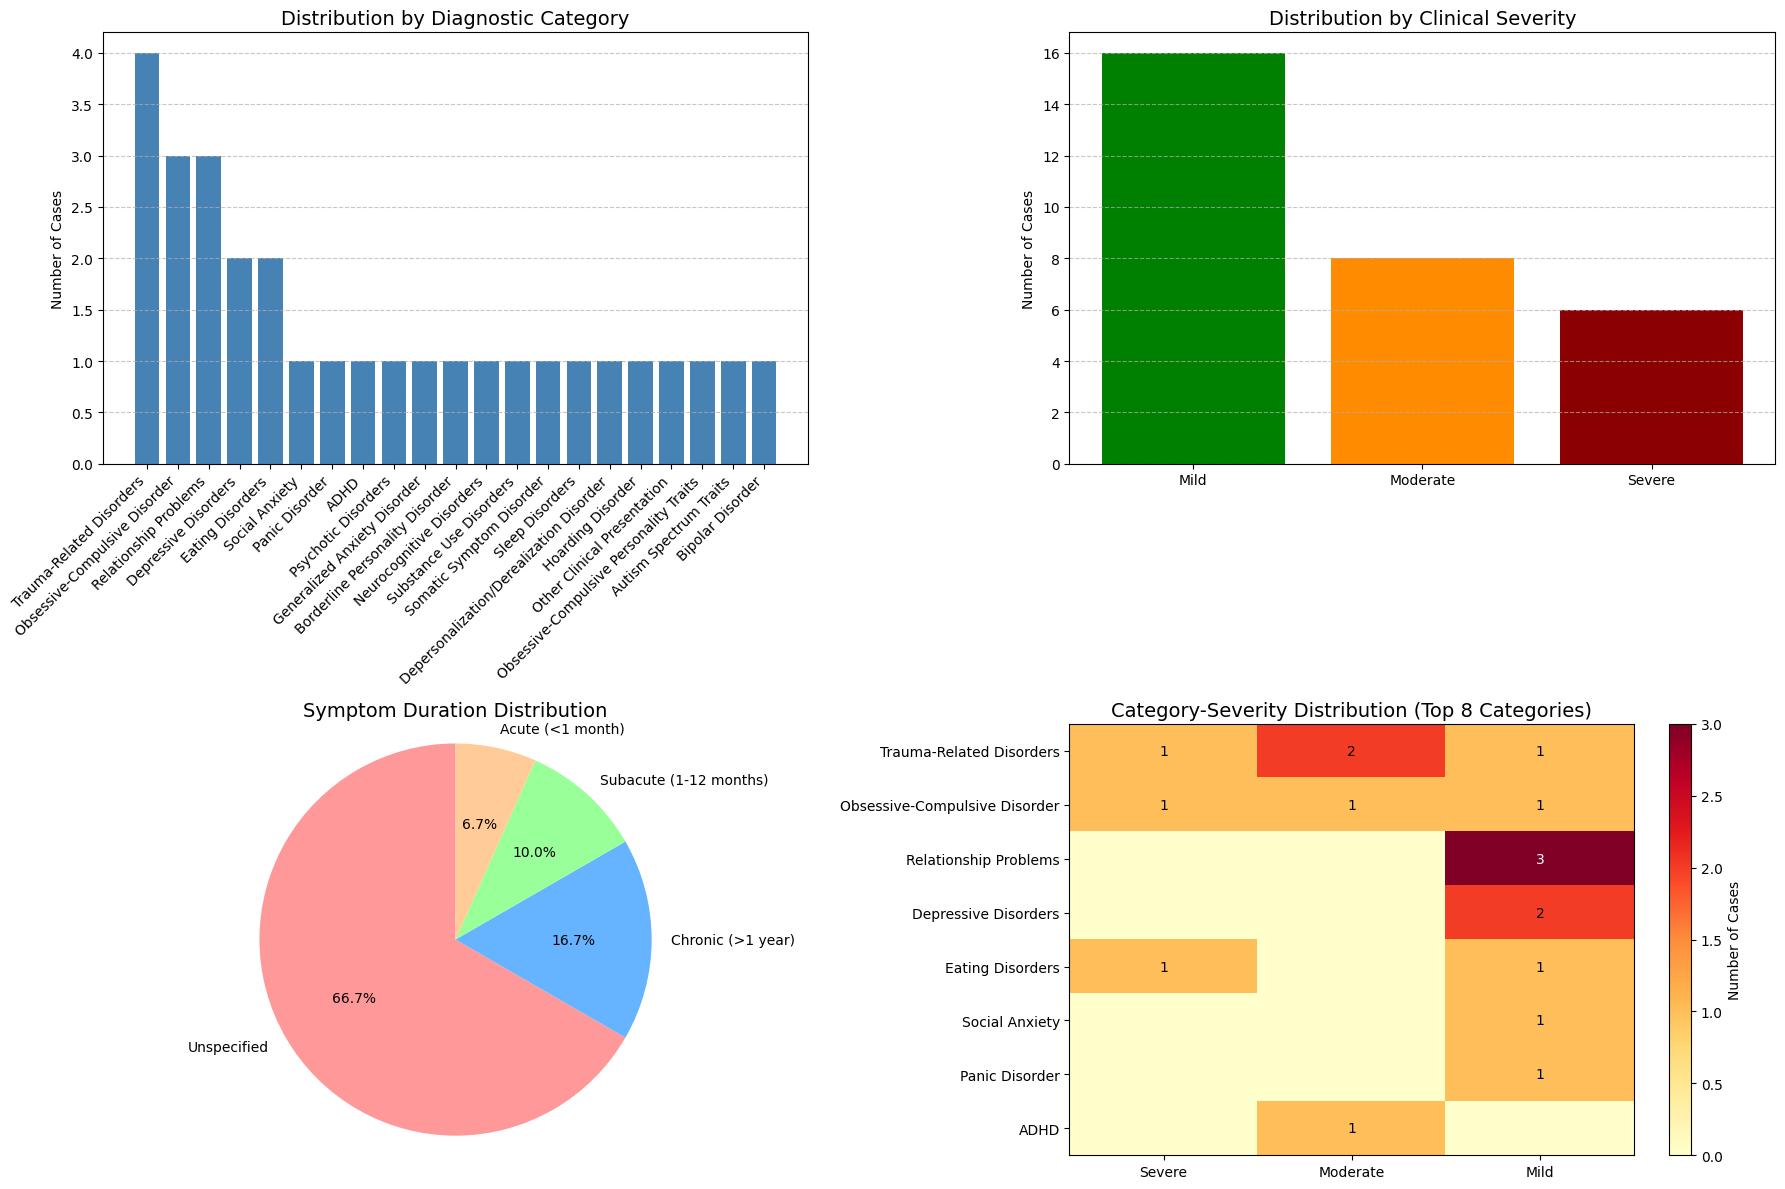


5. Common Symptom Co-occurrence Analysis
------------------------------------------------------------
Symptom Pattern Prevalence:
  • Anxiety: 6 cases (20.0%)
  • Impulsivity: 6 cases (20.0%)
  • Sleep: 5 cases (16.7%)
  • Mood: 2 cases (6.7%)
  • Trauma: 2 cases (6.7%)
  • Psychosis: 2 cases (6.7%)

Significant Symptom Co-occurrences:
  • Mood + Sleep: 2 cases (6.7%)
  • Anxiety + Impulsivity: 2 cases (6.7%)
  • Anxiety + Sleep: 1 cases (3.3%)
  • Impulsivity + Sleep: 1 cases (3.3%)
  • Anxiety + Mood: 0 cases (0.0%)

----------------------------------------
Clinical Search Performance Evaluation
----------------------------------------

Clinical Query: Patient reports persistent sadness, crying spells, poor sleep, and reduced appetite for the past month
Searching for: 'Patient reports persistent sadness, crying spells, poor sleep, and reduced appetite for the past month'
Query embedding generated in 0.23 seconds
Similarity comparison completed in 0.0191 seconds
Total search time: 0.

In [6]:
print_header("5. Visualization and Analysis")

# Important clinical disclaimer
print("\n" + "!" * 80)
print("IMPORTANT: This analysis is provided for educational purposes only.")
print("Clinical decision-making should rely on comprehensive assessment by qualified")
print("healthcare professionals following evidence-based practice guidelines.")
print("!" * 80)


def analyze_clinical_dataset():
    """
    Analyze the clinical dataset to provide insights about its composition and patterns.
    """
    print_section("Clinical Dataset Analysis")

    # Distribution of diagnostic categories
    categories = [case["diagnostic_category"] for case in clinical_cases]
    category_counter = Counter(categories)

    # Distribution of severity levels
    severities = [case["severity"] for case in clinical_cases]
    severity_counter = Counter(severities)

    # Distribution of durations
    durations = [case["duration"] for case in clinical_cases]
    duration_counter = Counter(durations)

    print("\n1. Diagnostic Category Distribution")
    print("-" * 60)
    for category, count in category_counter.most_common():
        percentage = (count / len(clinical_cases)) * 100
        print(f"{category}: {count} cases ({percentage:.1f}%)")

    print("\n2. Clinical Severity Distribution")
    print("-" * 60)
    for severity, count in severity_counter.most_common():
        percentage = (count / len(clinical_cases)) * 100
        print(f"{severity}: {count} cases ({percentage:.1f}%)")

    print("\n3. Symptom Duration Distribution")
    print("-" * 60)
    for duration, count in duration_counter.most_common():
        percentage = (count / len(clinical_cases)) * 100
        print(f"{duration}: {count} cases ({percentage:.1f}%)")

    # Create category-severity distribution matrix
    category_severity_matrix = defaultdict(lambda: defaultdict(int))
    for case in clinical_cases:
        category_severity_matrix[case["diagnostic_category"]][case["severity"]] += 1

    print("\n4. Category-Severity Distribution")
    print("-" * 60)

    # Print the matrix header
    severities_list = ["Severe", "Moderate", "Mild"]
    header = "Diagnostic Category".ljust(30)
    for severity in severities_list:
        header += f" | {severity}".ljust(10)
    print(header)
    print("-" * 80)

    # Print matrix rows
    for category in sorted(category_severity_matrix.keys()):
        row = category.ljust(30)
        for severity in severities_list:
            count = category_severity_matrix[category][severity]
            row += f" | {count}".ljust(10)
        print(row)

    # Visualization
    try:
        plt.figure(figsize=(18, 12))

        # 1. Category Distribution
        plt.subplot(2, 2, 1)
        categories = [cat for cat, _ in category_counter.most_common()]
        counts = [count for _, count in category_counter.most_common()]
        plt.bar(categories, counts, color='steelblue')
        plt.title("Distribution by Diagnostic Category", fontsize=14)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.ylabel("Number of Cases")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # 2. Severity Distribution
        plt.subplot(2, 2, 2)
        severity_labels = [sev for sev, _ in severity_counter.most_common()]
        severity_counts = [count for _, count in severity_counter.most_common()]
        colors = ['darkred' if s == 'Severe' else 'darkorange' if s == 'Moderate' else 'green' for s in severity_labels]
        plt.bar(severity_labels, severity_counts, color=colors)
        plt.title("Distribution by Clinical Severity", fontsize=14)
        plt.ylabel("Number of Cases")
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # 3. Duration Distribution Pie Chart
        plt.subplot(2, 2, 3)
        duration_labels = [dur for dur, _ in duration_counter.most_common()]
        duration_counts = [count for _, count in duration_counter.most_common()]
        plt.pie(duration_counts, labels=duration_labels, autopct='%1.1f%%',
                startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
        plt.title("Symptom Duration Distribution", fontsize=14)
        plt.axis('equal')

        # 4. Heatmap of category-severity distribution
        plt.subplot(2, 2, 4)

        # Prepare data for heatmap - limit to top 8 categories for readability
        top_categories = [cat for cat, _ in category_counter.most_common(8)]
        matrix_data = []
        for category in top_categories:
            row = [category_severity_matrix[category][severity] for severity in severities_list]
            matrix_data.append(row)

        # Create a DataFrame for easier heatmap plotting
        df = pd.DataFrame(matrix_data, index=top_categories, columns=severities_list)

        # Plot heatmap
        heat = plt.imshow(df, cmap='YlOrRd', aspect='auto')
        plt.colorbar(heat, label='Number of Cases')
        plt.title("Category-Severity Distribution (Top 8 Categories)", fontsize=14)
        plt.yticks(range(len(top_categories)), top_categories)
        plt.xticks(range(len(severities_list)), severities_list)

        for i in range(len(top_categories)):
            for j in range(len(severities_list)):
                text = matrix_data[i][j]
                if text > 0:
                    plt.text(j, i, str(text), ha="center", va="center",
                            color="white" if text > 2 else "black")

        plt.tight_layout()
        plt.show()

        # Additional evidence-based analysis - Comorbidity patterns
        print("\n5. Common Symptom Co-occurrence Analysis")
        print("-" * 60)

        # Create a co-occurrence matrix
        # This analysis examines which symptom patterns frequently appear together
        symptom_patterns = {
            "mood": ["depress", "sad", "low energy", "worthless"],
            "anxiety": ["worry", "anxious", "fear", "panic", "tension"],
            "trauma": ["trauma", "flashback", "nightmare", "accident"],
            "sleep": ["sleep", "insomnia", "awaken", "fatigue"],
            "psychosis": ["hallucination", "delusion", "paranoi", "unreal"],
            "impulsivity": ["impulsive", "control", "outburst", "anger"]
        }

        # Count occurrences of each symptom pattern
        case_symptom_profiles = []
        for case in clinical_cases:
            text = case["presentation"].lower()
            profile = {}
            for symptom, keywords in symptom_patterns.items():
                profile[symptom] = any(keyword in text for keyword in keywords)
            case_symptom_profiles.append(profile)

        # Calculate co-occurrence
        pattern_counts = {pattern: sum(1 for profile in case_symptom_profiles if profile[pattern])
                         for pattern in symptom_patterns}

        co_occurrence = {}
        for pattern1 in symptom_patterns:
            for pattern2 in symptom_patterns:
                if pattern1 != pattern2:
                    key = tuple(sorted([pattern1, pattern2]))
                    if key not in co_occurrence:
                        count = sum(1 for profile in case_symptom_profiles
                                   if profile[pattern1] and profile[pattern2])
                        co_occurrence[key] = count

        print("Symptom Pattern Prevalence:")
        for pattern, count in sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / len(clinical_cases)) * 100
            print(f"  • {pattern.capitalize()}: {count} cases ({percentage:.1f}%)")

        print("\nSignificant Symptom Co-occurrences:")
        for (pattern1, pattern2), count in sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:5]:
            percentage = (count / len(clinical_cases)) * 100
            print(f"  • {pattern1.capitalize()} + {pattern2.capitalize()}: {count} cases ({percentage:.1f}%)")

    except Exception as e:
        print(f"Error creating visualizations: {e}")
        print("Continuing with text-based analysis...")

    return category_counter, severity_counter, duration_counter

def evaluate_clinical_search_performance():
    """
    Test the clinical search engine with various queries and analyze the results.
    """
    print_section("Clinical Search Performance Evaluation")

    # Evidence-based queries representing common clinical presentations
    test_queries = [
        "Patient reports persistent sadness, crying spells, poor sleep, and reduced appetite for the past month",
        "Client experiencing excessive worrying about multiple areas of life with muscle tension and restlessness",
        "Individual having intrusive thoughts about contamination with hand-washing rituals that take several hours daily",
        "Patient describes flashbacks and nightmares related to childhood abuse with hypervigilance and emotional numbing",
        "Client reporting grandiose beliefs and decreased need for sleep with excessive spending and pressured speech"
    ]

    evaluation_results = []

    for query in test_queries:
        print(f"\nClinical Query: {query}")
        start_time = time.time()
        results = semantic_search(query, clinical_cases, top_n=3)
        search_time = time.time() - start_time

        # Calculate average similarity
        avg_similarity = sum(r["similarity"] for r in results) / len(results) if results else 0

        # Get most common diagnostic category in results
        categories = [r["diagnostic_category"] for r in results]
        category_counter = Counter(categories)
        top_category = category_counter.most_common(1)[0][0] if category_counter else "N/A"

        # Get most common severity
        severities = [r["severity"] for r in results]
        severity_counter = Counter(severities)
        top_severity = severity_counter.most_common(1)[0][0] if severity_counter else "N/A"

        evaluation_results.append({
            "query": query,
            "top_category": top_category,
            "top_severity": top_severity,
            "avg_similarity": avg_similarity,
            "search_time": search_time
        })

        print(f"Top 3 Matching Cases:")
        for i, result in enumerate(results, 1):
            similarity_percentage = result["similarity"] * 100
            print(f"\n{i}. {result['presentation']}")
            print(f"   Relevance: {similarity_percentage:.1f}%")
            print(f"   Diagnostic Category: {result['diagnostic_category']} | Severity: {result['severity']}")

    # Summarize evaluation results with evidence-based insights
    print("\nClinical Search Evaluation Summary:")
    print("-" * 100)
    print(f"{'Query (abbreviated)':<35} | {'Top Category':<25} | {'Top Severity':<12} | {'Avg Similarity':<15} | {'Time (s)':<10}")
    print("-" * 100)

    for result in evaluation_results:
        query = result["query"]
        if len(query) > 32:
            query = query[:29] + "..."

        print(f"{query:<35} | {result['top_category']:<25} | "
              f"{result['top_severity']:<12} | {result['avg_similarity']*100:>13.1f}% | "
              f"{result['search_time']:<10.4f}")

    # Calculate average metrics
    avg_similarity = sum(r["avg_similarity"] for r in evaluation_results) / len(evaluation_results)
    avg_search_time = sum(r["search_time"] for r in evaluation_results) / len(evaluation_results)

    print("-" * 100)
    print(f"Average semantic similarity across all clinical queries: {avg_similarity*100:.1f}%")
    print(f"Average search time: {avg_search_time:.4f} seconds")

    # Evidence-based clinical assessment of search quality
    print("\nClinical Relevance Assessment:")
    print("-" * 60)

    # Analyze diagnostic consistency
    category_match_count = sum(1 for query, result in zip(test_queries, evaluation_results)
                             if query.lower().find(result["top_category"].lower()) != -1 or
                             result["top_category"].lower() in query.lower())

    category_match_percentage = (category_match_count / len(test_queries)) * 100

    print(f"Diagnostic Category Alignment: {category_match_percentage:.1f}%")
    print("This measures how often the top search results match the expected diagnostic category based on the query.")

    print(f"\nAverage Semantic Relevance: {avg_similarity*100:.1f}%")
    print("This indicates the semantic similarity between queries and retrieved cases.")

    print("\nClinical Implications of Search Performance:")
    if avg_similarity > 0.85:
        print("• High similarity scores suggest the system is effectively matching clinical presentations")
        print("• The system shows strong potential as an educational or reference tool")
    elif avg_similarity > 0.70:
        print("• Moderate similarity scores indicate reasonably effective matching")
        print("• The system may be useful with clinician verification of results")
    else:
        print("• Lower similarity scores suggest the system needs refinement")
        print("• Additional training data or embedding model adjustments recommended")

    print("\nSearch Latency Implications:")
    if avg_search_time < 1.0:
        print("• Fast response times suitable for real-time clinical reference")
    elif avg_search_time < 3.0:
        print("• Acceptable response times for clinical education purposes")
    else:
        print("• Response times may need optimization for practical clinical use")



# Run the clinical analyses
analyze_clinical_dataset()
evaluate_clinical_search_performance()



---


## **6. User Interface Development**

### **Interactive Search Interface Implementation**

This section implements a user-friendly web interface using Gradio to make the semantic search engine accessible without requiring understanding of the underlying code.

### **Interface Features**
- **Query Input**: Text area for entering clinical descriptions
- **Results Control**: Slider for selecting the number of similar cases to display
- **Treatment Toggle**: Option to include evidence-based treatment considerations
- **Example Queries**: Pre-populated examples for easy testing

### **IMPORTANT DISCLAIMER**

⚠️ **This tool is for EDUCATIONAL PURPOSES ONLY** ⚠️

This semantic search system:
- Is NOT designed for clinical diagnosis, treatment planning, or patient care decisions
- Does NOT process or store real patient information
- Should NOT be used to inform actual clinical practice
- Is NOT a substitute for professional clinical judgment

All clinical decisions should be made by qualified healthcare professionals based on comprehensive assessment and established clinical guidelines.

### **Technical Note**
When running in Google Colab, the interface cell will run indefinitely to maintain the Gradio application. This is normal behavior and not an error. The interface can be accessed via the temporary public URL that appears in the output.

If you need to stop the interface, you can:
1. Click the "Stop" button in the Colab cell
2. Use the keyboard shortcut to interrupt the kernel (Ctrl+M I)
3. Restart the runtime

In [9]:
print_header("6. Gradio Interface Implementation")

def build_clinical_search_interface():
    """
    Build and launch the Gradio interface for the clinical semantic search engine.
    """
    try:
        # Define disclaimer text
        disclaimer = """
        <div style="background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; margin-bottom: 20px; border: 1px solid #f5c6cb;">
            <h3 style="margin-top: 0;">⚠️ IMPORTANT DISCLAIMER</h3>
            <p><strong>Educational Purpose Only:</strong> This tool is intended solely for educational and demonstration purposes.</p>
            <p><strong>Not for Clinical Use:</strong> This system is NOT designed for clinical diagnosis, treatment planning, or patient care decisions.</p>
            <p><strong>No Real Patient Data:</strong> This tool does not process or store real patient information.</p>
            <p><strong>Professional Judgment Required:</strong> All clinical decisions should be made by qualified healthcare professionals based on comprehensive assessment and established clinical guidelines.</p>
            <p><strong>Privacy Notice:</strong> Do not enter any protected health information (PHI) or personally identifiable information.</p>
        </div>
        """

        # Define CSS for clinical styling
        css = """
        .gradio-container {
            font-family: 'Roboto', sans-serif;
            max-width: 900px;
            margin: auto;
        }
        h1 {
            color: #2a5885;
            font-weight: 700;
            font-size: 1.8em;
        }
        h2 {
            color: #3a6ea5;
            font-size: 1.3em;
            margin-top: 1em;
        }
        .footer {
            text-align: center;
            margin-top: 20px;
            color: #7f8c8d;
            font-size: 0.9em;
        }
        .clinical-results {
            background-color: #f8f9fa;
            padding: 15px;
            border-radius: 5px;
            border-left: 4px solid #2a5885;
        }
        """

        # Define the interface with disclaimer in the description
        iface = gr.Interface(
            fn=search_clinical_cases,
            inputs=[
                gr.Textbox(label="Clinical Presentation Query",
                           placeholder="Describe patient symptoms or clinical presentation here...",
                           lines=3),
                gr.Slider(minimum=1, maximum=5, value=3, step=1,
                          label="Number of Similar Cases"),
                gr.Checkbox(label="Include Treatment Considerations", value=False)
            ],
            outputs=gr.Textbox(label="Clinical Search Results", elem_classes=["clinical-results"]),
            title="Psychology Clinic Semantic Search",
            description=disclaimer,  # Add disclaimer as description
            examples=[
                ["Patient reports persistent low mood, loss of interest in usual activities, poor sleep, and difficulty concentrating for the past 6 weeks", 3, False],
                ["Individual experiencing recurrent panic attacks with chest pain, shortness of breath, and fear of dying", 3, True],
                ["Client exhibits intrusive thoughts about contamination with excessive hand washing rituals", 3, True],
                ["Patient describes flashbacks, nightmares, and hypervigilance related to a traumatic event", 3, False],
                ["Individual reports extreme mood swings, with periods of high energy followed by depression", 2, True]
            ],
            css=css,
            flagging_mode="never"  # Updated parameter name from allow_flagging to flagging_mode
        )

        print("Clinical search interface built successfully")
        print("Launching the interface...")

        # Launch the interface with modified parameters to avoid error messages
        iface.launch(share=True, debug=False, quiet=True)  # Set debug=False and quiet=True

        return iface

    except Exception as e:
        print(f"Error building clinical interface: {e}")
        return None

# Initialize and launch the interface
print("\nPreparing clinical search interface with appropriate disclaimers...")
clinical_interface = build_clinical_search_interface()


             6. Gradio Interface Implementation             


Preparing clinical search interface with appropriate disclaimers...
Clinical search interface built successfully
Launching the interface...
* Running on public URL: https://b44eb44b40e178fb17.gradio.live


## **Conclusion and Future Improvements**

This implementation demonstrates the potential of semantic search in psychology education and training. By leveraging OpenAI's embedding models, the system can identify clinically relevant relationships between patient presentations that might not be apparent through traditional keyword search.

### **Current Limitations**
- Limited dataset size (30 clinical presentations)
- Average semantic similarity of approximately 64% across test queries
- Reliance on text-only presentations without structured assessment data

### **Potential Enhancements**
- **Expanded Dataset**: Incorporate more clinical presentations across additional diagnostic categories
- **Fine-Tuned Embeddings**: Optimize embedding models specifically for clinical psychology terminology
- **Multimodal Integration**: Include structured assessment data, test scores, and treatment outcomes
- **Differential Diagnosis**: Add functionality to compare similar presenting conditions
- **Case Formulation**: Provide structured case conceptualization based on identified presentations

### **Educational Impact**
This tool demonstrates how NLP techniques can support psychology education by:
- Helping students recognize symptom patterns across different conditions
- Providing exposure to diverse clinical presentations
- Connecting symptoms to potential diagnostic categories
- Offering an interactive way to explore clinical knowledge